In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [2]:
df=pd.read_csv('model_data.csv')

In [3]:
df.drop(columns=['Unnamed: 0','MA_vs_AI',"GT_vs_AI",'date'],inplace=True)
df

,Tree,Ground Truth,Number of manual annotations,AI detections,variety,GS,field
0,1,7,7,3,1,83,8
1,3,25,15,20,1,83,8
2,4,19,3,3,1,83,8
3,5,4,20,29,1,83,8
4,6,38,13,13,1,83,8
...,...,...,...,...,...,...,...
413,19,23,34,41,5,84,5
414,20,32,47,46,5,84,5
415,21,6,6,7,5,84,5
416,22,23,27,31,5,84,5


In [4]:
test_df=df[df['variety'] ==2]

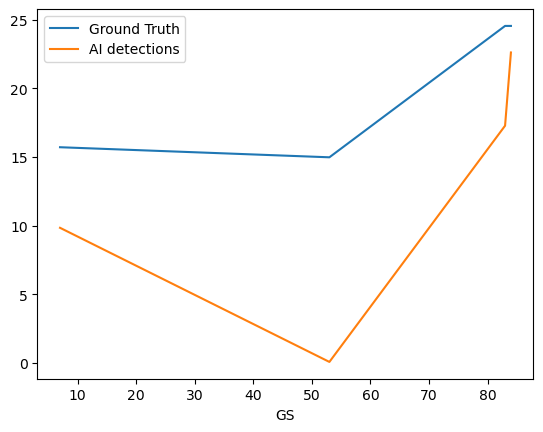

In [5]:
test_df.groupby('GS')['Ground Truth','AI detections'].mean().plot();

In [6]:
test_df.sum()

Tree                            2070
Ground Truth                    1656
Number of manual annotations    1149
AI detections                    895
variety                          180
GS                              4305
field                            210
dtype: int64

## IsolationForest

In [7]:
iforest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iforest.fit(test_df)
pred = iforest.predict(test_df)
scores = iforest.decision_function(test_df)

In [8]:
test_df['scores'] = scores
test_df['anomaly_label'] = pred
test_df['anomaly'] = test_df['anomaly_label'].apply(lambda x: 'outlier' if x == -1 else 'inlier')
test_df=test_df[test_df['anomaly'] == 'inlier']
test_df.drop(columns=['scores','anomaly_label','anomaly'],inplace=True)

# Boxplot

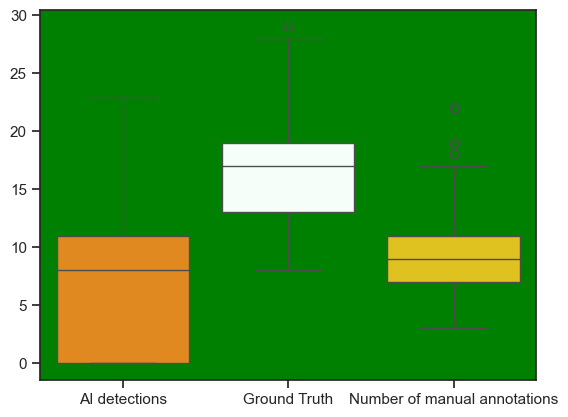

In [9]:
columns_to_plot =['AI detections','Ground Truth',"Number of manual annotations"]
sns.set(style="ticks")
box_colors = ["darkorange","mintcream",'gold']
ax = sns.boxplot(data=test_df[columns_to_plot], palette=box_colors)
ax.set_facecolor("green")
plt.show()

# Pairplot

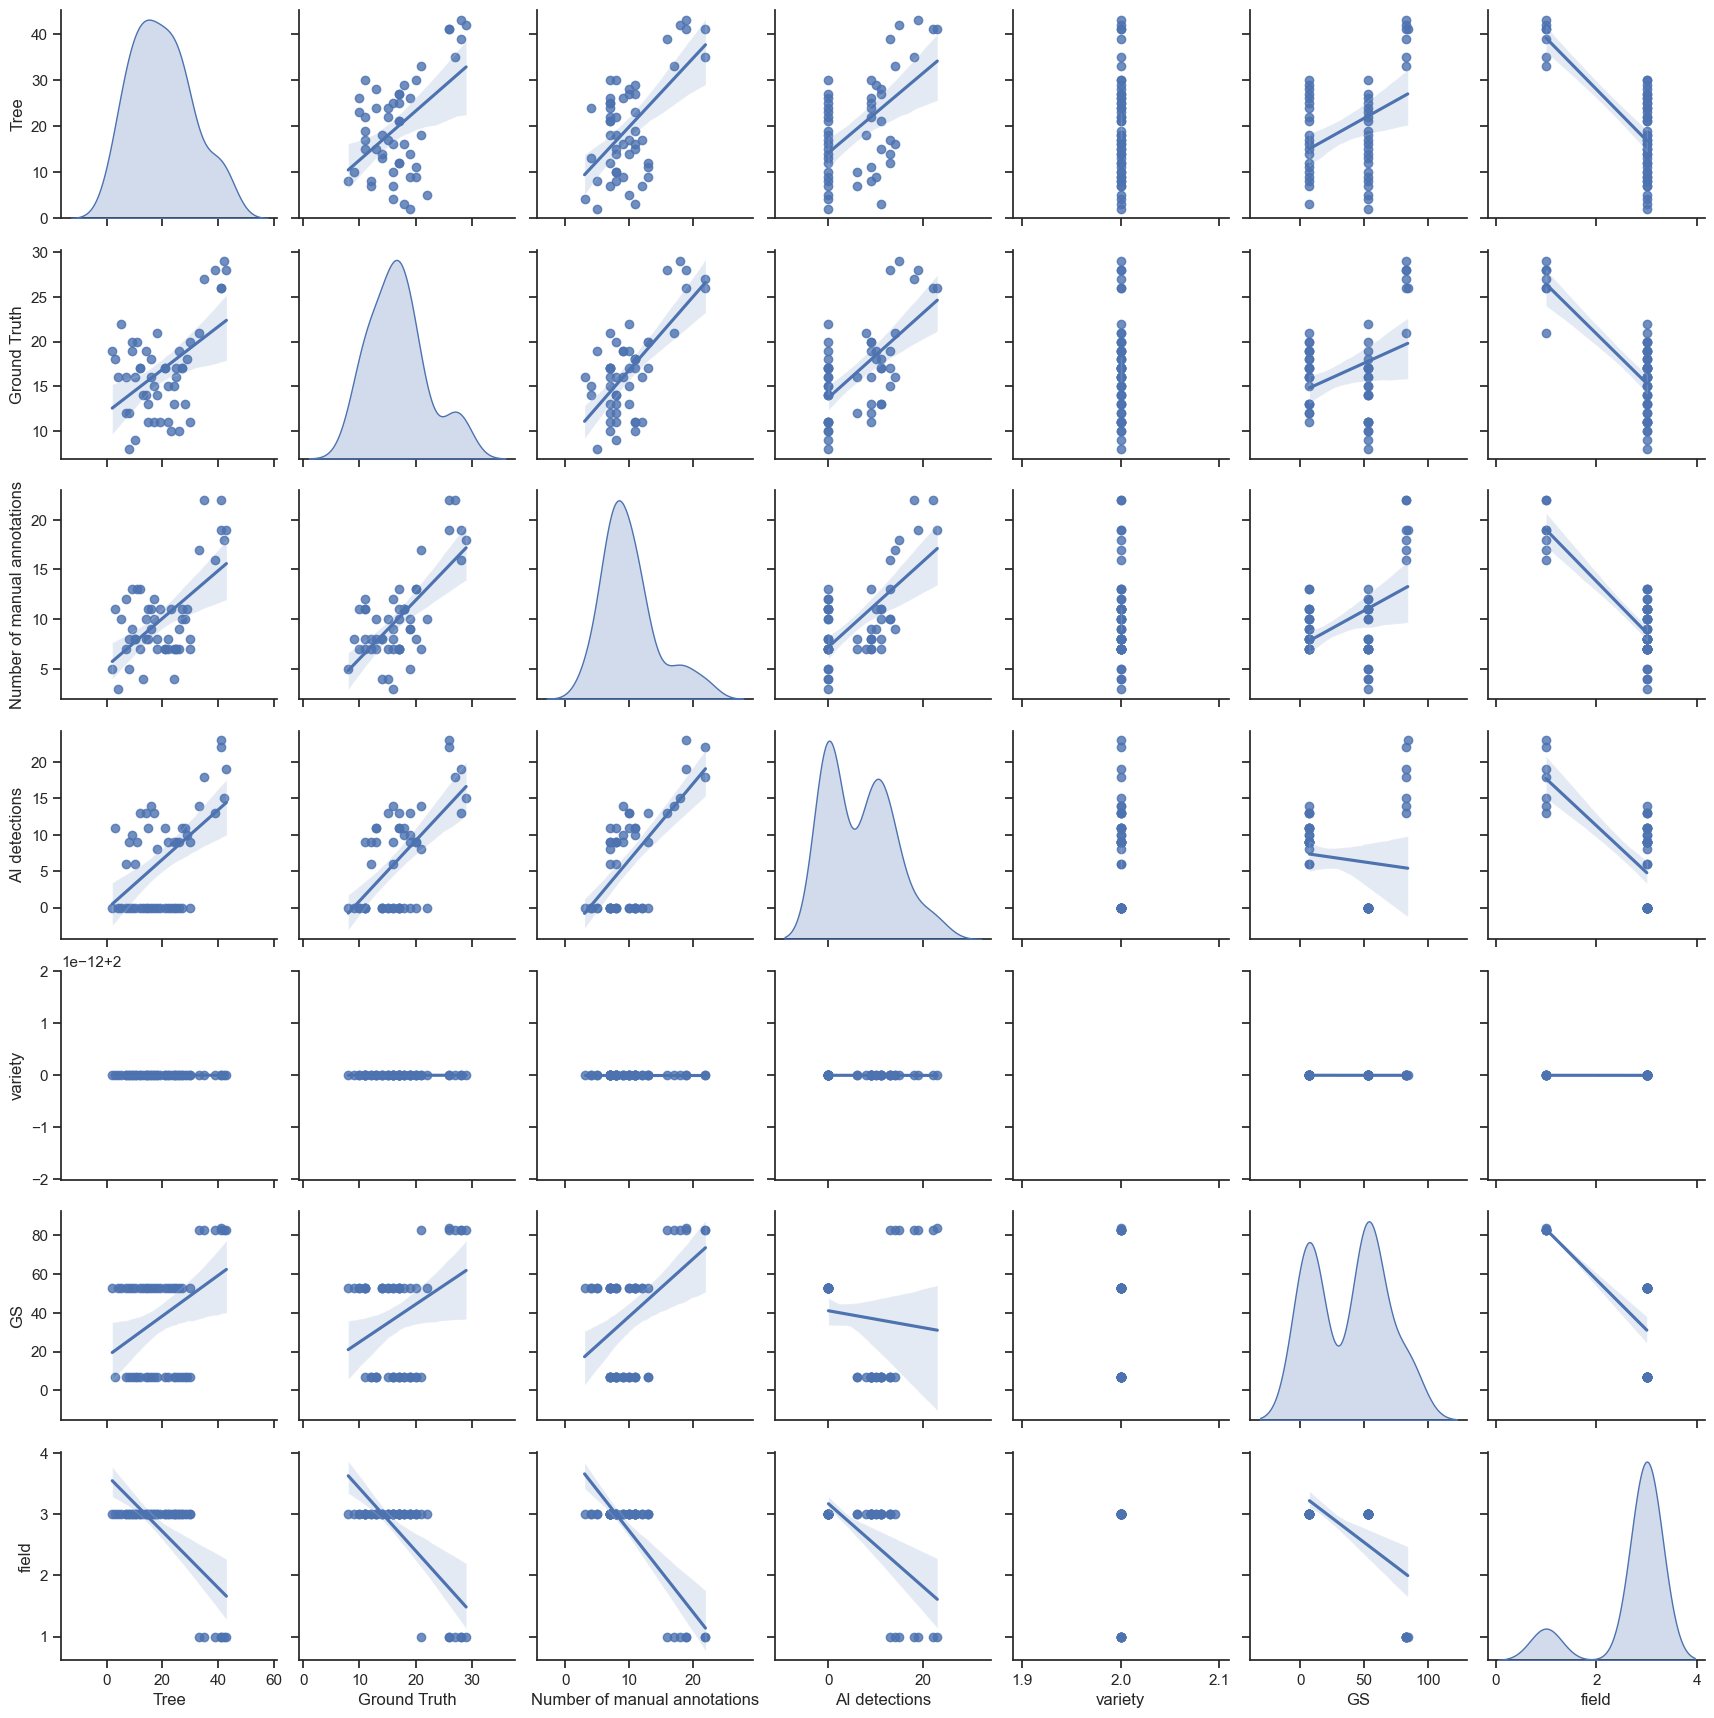

In [10]:
sns.pairplot(test_df,diag_kind='kde',kind='reg');

# LinearRegression model with mean correction

In [11]:
# Mean Function
original_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Analyze the distribution
mean_original = np.mean(original_counts)
std_original = np.std(original_counts)

# Determine the scaling factor
scaling_factor = np.mean(ground_truth) / mean_original

# Apply the scaling factor
scaled_counts = original_counts * scaling_factor

In [12]:
X=test_df.drop(columns=['Tree','Ground Truth','Number of manual annotations'])
X['scaled']=scaled_counts
y=test_df['Ground Truth']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lin = model.predict(X_test)
print('Mean Squared Error :', mean_squared_error(y_test, y_pred_lin,squared=False))
print('R2 score : ', r2_score(y_test, y_pred_lin))

Mean Squared Error : 2.549674979610907
R2 score :  0.5960873592722407


In [15]:
predictions=pd.DataFrame(y_test)

In [16]:
predictions['model']=y_pred_lin
predictions['AI'] = X_test['AI detections']
predictions.sum()

Ground Truth    215.000000
model           206.485694
AI               66.000000
dtype: float64

In [17]:
predictions['GS'] =  X_test['GS']
predictions

,Ground Truth,model,AI,GS
337,11,14.248948,0,53
268,16,15.765604,6,7
288,20,16.023835,9,7
343,17,14.248948,0,53
261,18,16.195990,11,7
282,13,16.023835,9,7
335,11,14.248948,0,53
322,16,14.248948,0,53
340,15,14.248948,0,53
270,17,16.368144,13,7


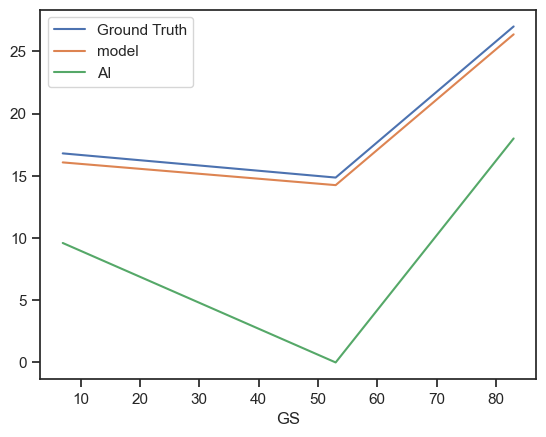

In [18]:
predictions.groupby('GS')['Ground Truth','model','AI'].mean().plot();

# LinearRegression model with quantile correction

In [19]:
# Quantile Function
predicted_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Calculate quantiles
predicted_quantiles = np.percentile(predicted_counts, np.arange(0, 101))
ground_truth_quantiles = np.percentile(ground_truth, np.arange(0, 101))

# Quantile mapping function
def quantile_mapping(prediction, predicted_quantiles, ground_truth_quantiles):
    mapped_quantile = np.interp(np.percentile(prediction, np.arange(0, 101)),
                                predicted_quantiles, ground_truth_quantiles)
    mapped_prediction = np.interp(prediction, predicted_quantiles, mapped_quantile)
    return mapped_prediction

# Apply quantile mapping
adjusted_counts = quantile_mapping(predicted_counts, predicted_quantiles, ground_truth_quantiles)

In [20]:
X=test_df.drop(columns=['Tree','Number of manual annotations','Ground Truth'])
X['scaled_counts']=adjusted_counts
y=test_df['Ground Truth']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lin = model.predict(X_test)
print('Root Mean Squared Error :', mean_squared_error(y_test, y_pred_lin,squared=False))
print('R2 score:', r2_score(y_test, y_pred_lin))

Root Mean Squared Error : 2.5541370928032876
R2 score: 0.5946723702893811


In [23]:
predictions=pd.DataFrame(y_test)
predictions['model']=y_pred_lin
predictions['AI']=X_test['AI detections']
predictions['GS'] =  X_test['GS']

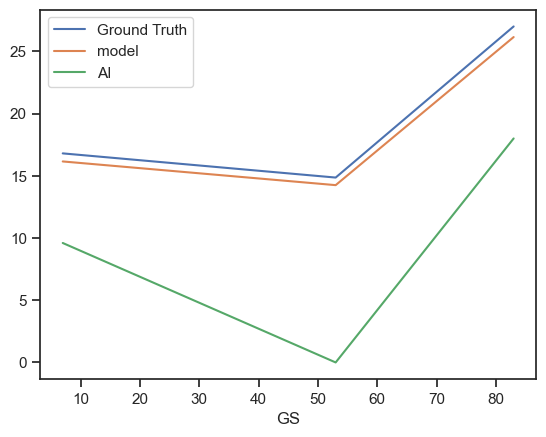

In [24]:
predictions.groupby('GS')['Ground Truth','model','AI'].mean().plot();

# ElasticNet model with mean correction

In [25]:
# Mean Function
original_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Analyze the distribution
mean_original = np.mean(original_counts)
std_original = np.std(original_counts)

# Determine the scaling factor
scaling_factor = np.mean(ground_truth) / mean_original

# Apply the scaling factor
scaled_counts = original_counts * scaling_factor

In [26]:
X=test_df.drop(columns=['Tree','Number of manual annotations','Ground Truth'])
X['scaled_counts']=scaled_counts
y=test_df['Ground Truth']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [28]:
regr = ElasticNet(random_state=13,alpha=0.01)
regr.fit(X_train, y_train)

ElasticNet(alpha=0.01, random_state=13)

In [29]:
print('Root Mean Squared Error :', mean_squared_error(y_test, regr.predict(X_test),squared=False))
print('R2 score:', r2_score(y_test, regr.predict(X_test)))

Root Mean Squared Error : 2.5469616037440206
R2 score: 0.5969465932169387


In [30]:
predictions=pd.DataFrame(y_test)
predictions['model']=regr.predict(X_test)
predictions['AI']=X_test['AI detections']
predictions['GS'] =  X_test['GS']

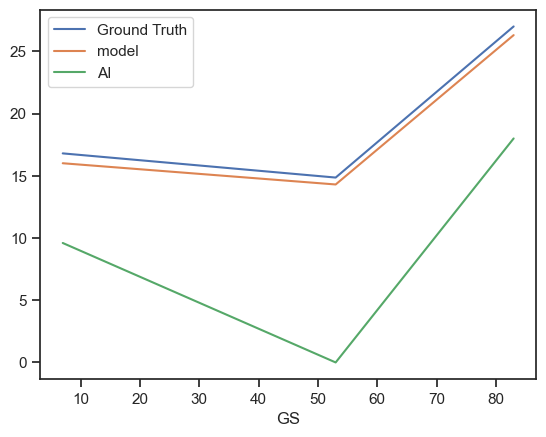

In [31]:
predictions.groupby('GS')['Ground Truth','model','AI'].mean().plot();

# ElasticNet model with quantile correction

In [32]:
# Quantile Function
predicted_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Calculate quantiles
predicted_quantiles = np.percentile(predicted_counts, np.arange(0, 101))
ground_truth_quantiles = np.percentile(ground_truth, np.arange(0, 101))

# Quantile mapping function
def quantile_mapping(prediction, predicted_quantiles, ground_truth_quantiles):
    mapped_quantile = np.interp(np.percentile(prediction, np.arange(0, 101)),
                                predicted_quantiles, ground_truth_quantiles)
    mapped_prediction = np.interp(prediction, predicted_quantiles, mapped_quantile)
    return mapped_prediction

# Apply quantile mapping
adjusted_counts = quantile_mapping(predicted_counts, predicted_quantiles, ground_truth_quantiles)

In [33]:
X=test_df.drop(columns=['Tree','Number of manual annotations','Ground Truth'])
X['scaled_counts']=adjusted_counts
y=test_df['Ground Truth']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [35]:
regr = ElasticNet(random_state=13,max_iter=1000000)
regr.fit(X_train, y_train)

ElasticNet(max_iter=1000000, random_state=13)

In [36]:
print('Root Mean Squared Error :', mean_squared_error(y_test, regr.predict(X_test),squared=False))
print('R2 score:', r2_score(y_test, regr.predict(X_test)))

Root Mean Squared Error : 2.6082021455160427
R2 score: 0.5773310974313277


In [37]:
predictions=pd.DataFrame(y_test)
predictions['model']=regr.predict(X_test)
predictions['AI']=X_test['AI detections']
predictions['GS'] =  X_test['GS']

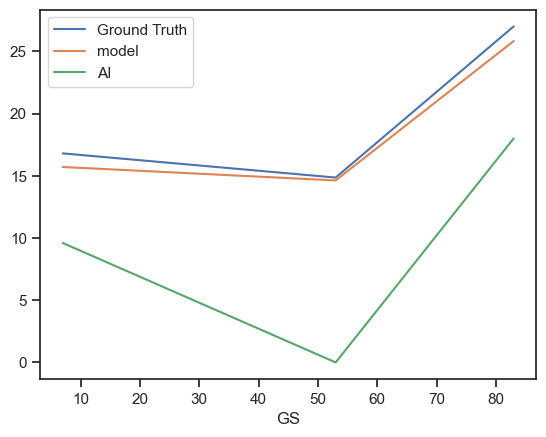

In [38]:
predictions.groupby('GS')['Ground Truth','model','AI'].mean().plot();

# DecisionTreeRegressor model with mean correction

In [39]:
# Mean Function
original_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Analyze the distribution
mean_original = np.mean(original_counts)
std_original = np.std(original_counts)

# Determine the scaling factor
scaling_factor = np.mean(ground_truth) / mean_original

# Apply the scaling factor
scaled_counts = original_counts * scaling_factor

In [40]:
X=test_df.drop(columns=['Tree','Number of manual annotations','Ground Truth'])
X['scaled_counts']=scaled_counts
y=test_df['Ground Truth']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [42]:
regressor = DecisionTreeRegressor(random_state=13,max_depth=7)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7, random_state=13)

In [43]:
y_pred=regressor.predict(X_test)

In [44]:
print('Root Mean Squared Error :', mean_squared_error(y_test, y_pred,squared=False))
print('R2 score:', r2_score(y_test, y_pred))

Root Mean Squared Error : 2.876395982154378
R2 score: 0.485938419117647


In [45]:
predictions=pd.DataFrame(y_test)
predictions['model']=regr.predict(X_test)
predictions['AI']=X_test['AI detections']
predictions['GS'] =  X_test['GS']

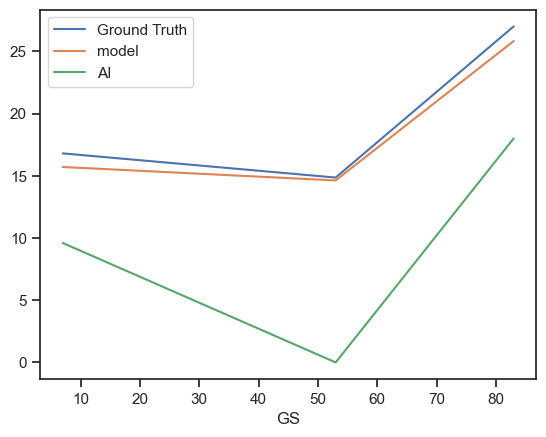

In [46]:
predictions.groupby('GS')['Ground Truth','model','AI'].mean().plot();

# DecisionTreeRegressor model with quantile correction

In [47]:
# Quantile Function
predicted_counts = test_df['AI detections']
ground_truth = test_df['Ground Truth']

# Calculate quantiles
predicted_quantiles = np.percentile(predicted_counts, np.arange(0, 101))
ground_truth_quantiles = np.percentile(ground_truth, np.arange(0, 101))

# Quantile mapping function
def quantile_mapping(prediction, predicted_quantiles, ground_truth_quantiles):
    mapped_quantile = np.interp(np.percentile(prediction, np.arange(0, 101)),
                                predicted_quantiles, ground_truth_quantiles)
    mapped_prediction = np.interp(prediction, predicted_quantiles, mapped_quantile)
    return mapped_prediction

# Apply quantile mapping
adjusted_counts = quantile_mapping(predicted_counts, predicted_quantiles, ground_truth_quantiles)

In [48]:
X=test_df.drop(columns=['Tree','Number of manual annotations','Ground Truth'])
X['scaled_counts']=adjusted_counts
y=test_df['Ground Truth']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [50]:
regressor = DecisionTreeRegressor(random_state=13,max_depth=7)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=7, random_state=13)

In [51]:
y_pred=regressor.predict(X_test)

In [52]:
print('Root Mean Squared Error :', mean_squared_error(y_test, y_pred,squared=False))
print('R2 score:', r2_score(y_test, y_pred))

Root Mean Squared Error : 2.876395982154378
R2 score: 0.485938419117647


In [53]:
predictions=pd.DataFrame(y_test)
predictions['model']=regr.predict(X_test)
predictions['AI detections']= X_test['AI detections']
predictions['GS'] = X_test['GS']
predictions.sum()

Ground Truth     215.000000
model            206.746184
AI detections     66.000000
GS               489.000000
dtype: float64

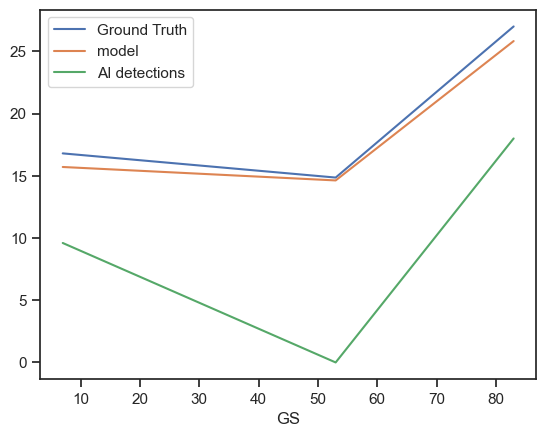

In [54]:
predictions.groupby('GS')['Ground Truth','model','AI detections'].mean().plot();